In [1]:
!pip install tensorflow==2.3.0 numpy==1.18.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.utils import class_weight

In [5]:
train_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain'
val_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/ValData'

In [6]:
## check to see how many classes present in the train dataset

num_classes_train = len(os.listdir(train_path))

print("There are %d classes present in the train datset." %num_classes_train)

There are 4 classes present in the train datset.


In [7]:
## check to see how many classes present in the valdation dataset

num_classes_val = len(os.listdir(val_path))

print("There are %d classes present in the validation dataset. " %num_classes_val)

There are 4 classes present in the validation dataset. 


In [8]:
##  we'll explore more of the train dataset..

BP_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/BacterialPneumonia'
img_list_bp = os.listdir(BP_path)

print('There are %d images of Bacterial Pneumonia present in the Train dataste.' %(len(img_list_bp)))

There are 650 images of Bacterial Pneumonia present in the Train dataste.


In [9]:
covid_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/COVID-19'
img_list_covid = os.listdir(covid_path)

print('There are %d images of COVID-19 present in the Train dataste.' %(len(img_list_covid)))

There are 60 images of COVID-19 present in the Train dataste.


In [10]:
normal_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/Normal'
img_list_normal = os.listdir(normal_path)

print('There are %d images of Normal lung present in the Train dataste.' %(len(img_list_normal)))

There are 880 images of Normal lung present in the Train dataste.


In [11]:
VP_path = '/content/drive/MyDrive/Colab Notebooks/data_covid/NonAugmentedTrain/ViralPneumonia'
img_list_vp = os.listdir(VP_path)

print('There are %d images of Viral Pneumonia present in the Train dataste.' %(len(img_list_vp)))

There are 412 images of Viral Pneumonia present in the Train dataste.


In [12]:
Batch_size = 32
img_size = (224,224)

In [13]:
train_ds = image_dataset_from_directory(train_path,
                                        batch_size=Batch_size,
                                        image_size=img_size,
                                        shuffle=True) 

Found 2002 files belonging to 4 classes.


In [14]:
val_ds = image_dataset_from_directory(val_path,
                                      batch_size=Batch_size,
                                      image_size=img_size,
                                      shuffle=True)

Found 988 files belonging to 4 classes.


In [15]:
class_names = train_ds.class_names
class_names

['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia']

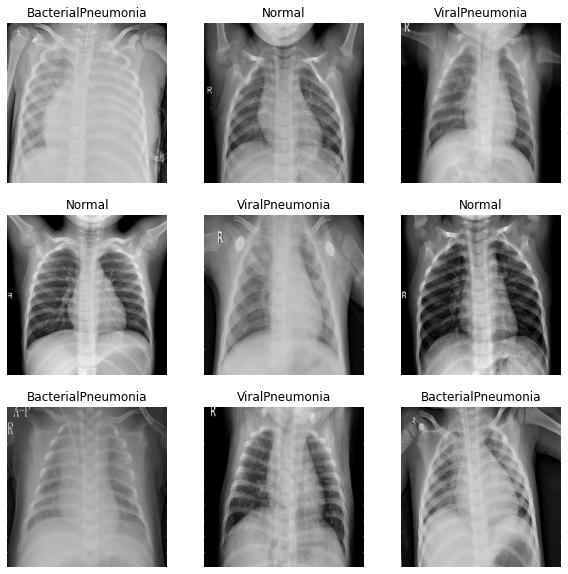

In [16]:
## lets check to see that the data flow properly through the input pipelines..

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [17]:
## The original dataset doest not contain the test dataset, so we create one. To do so we need to detremine
## how many batches of data are available in the validation dataset using tf.data.experimental.cardinality and then 
## move 20% of them to the test dataset..

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [18]:
print("Number of Validation batches : %d" % tf.data.experimental.cardinality(val_ds))
print("Number of Test batches : %d" % tf.data.experimental.cardinality(test_ds))

Number of Validation batches : 25
Number of Test batches : 6


In [19]:
## Using data augmentation.. This helps the model to expose different aspects of the training data and thus
## reduce Overfitting

data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                         tf.keras.layers.experimental.preprocessing.RandomZoom(0.5, 0.3),
                                         tf.keras.layers.experimental.preprocessing.RandomHeight(0.2)                                         
                                         ])

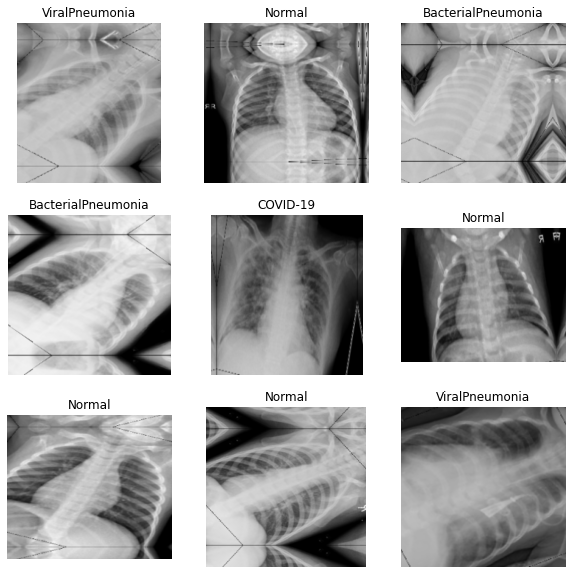

In [20]:
## lets apply the augmentataion techinque to few images and see the results..

plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    aug_image = data_augmentation(tf.expand_dims(images[i],axis=0))
    plt.imshow(aug_image[0] / 255)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [21]:
## we use 'tf.keras.applications.resnet.preprocess_input' for preprocessing..

preprocess_input = tf.keras.applications.resnet.preprocess_input

In [22]:
## lets create a base ResNet50 base model..

img_shape = img_size + (3,)
res_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=img_shape)

94773248/94765736 [==============================] - 1s 0us/step


In [23]:
res_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [24]:
## constructing a prediction layer..

num_classes = num_classes_train

prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

In [25]:
## Build a model by chaining together the data augmentation, preprocessing, base_model.. 
## use training=False as our model contains a BatchNormalization layer.

inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = res_model(x, training=False)
x =  GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [26]:
## compile the model..
base_lr =0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, None, 224, 3)      0         
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, None, 224, 3)]    0         
_________________________________________________________________
tf_op_layer_BiasAdd (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

In [31]:
class_weights = class_weight.compute_class_weight(
               'balanced',
                classes=np.unique(train_ds.class_names), 
                y=train_ds.class_names)

train_class_weights = dict(enumerate(class_weights))

print(train_class_weights)

{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [32]:
## training the model..
initial_epochs = 10

history = model.fit(train_ds,
                    steps_per_epoch=len(train_ds),
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    validation_steps=len(val_ds),
                    class_weight=train_class_weights
                    )

Epoch 1/10
63/63 [==============================] - 2796s 44s/step - loss: 0.9812 - accuracy: 0.5969 - val_loss: 0.7667 - val_accuracy: 0.7224
Epoch 2/10
63/63 [==============================] - 1362s 22s/step - loss: 0.6903 - accuracy: 0.7108 - val_loss: 0.6276 - val_accuracy: 0.7085
Epoch 3/10
63/63 [==============================] - 1362s 22s/step - loss: 0.6294 - accuracy: 0.7308 - val_loss: 0.6361 - val_accuracy: 0.7337
Epoch 4/10
63/63 [==============================] - 1386s 22s/step - loss: 0.5938 - accuracy: 0.7498 - val_loss: 0.5986 - val_accuracy: 0.7889
Epoch 5/10
63/63 [==============================] - 1410s 22s/step - loss: 0.5359 - accuracy: 0.7612 - val_loss: 0.5150 - val_accuracy: 0.7601
Epoch 6/10
63/63 [==============================] - 1378s 22s/step - loss: 0.6033 - accuracy: 0.7478 - val_loss: 0.7232 - val_accuracy: 0.7550
Epoch 7/10
63/63 [==============================] - 1385s 22s/step - loss: 0.5447 - accuracy: 0.7667 - val_loss: 0.6825 - val_accuracy: 0.7374

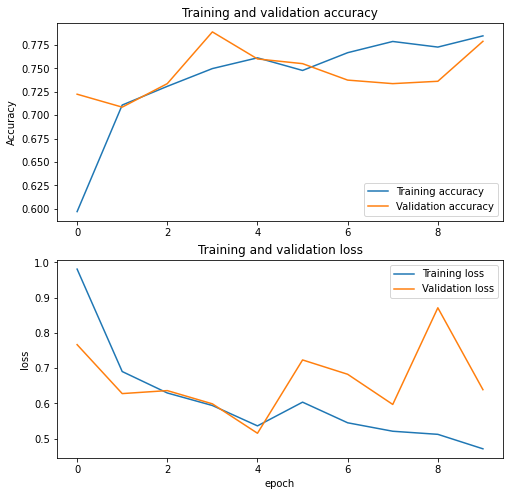

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.ylabel("Accuracy")
#plt.ylim([min(plt.ylim()),1])
plt.title("Training and validation accuracy")

plt.subplot(2,1,2)
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend(loc='upper right')
plt.ylabel("loss")
#plt.ylim(0,1.0)
plt.title("Training and validation loss")
plt.xlabel('epoch')
plt.show()

In [34]:
### Fine Tuning..

In [35]:
## lets check how many layers in the ResNet50 are trainable..

res_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(res_model.layers))


Number of layers in the base model:  175


In [36]:
## lets check out the layers by name

for i , layer in enumerate(res_model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [37]:
## lets start fine tune the model from layer 143(the last conv layer conv5)

fine_tune_at = 143

for layer in res_model.layers[:fine_tune_at]:
  layer.trainable = False

for layer in res_model.layers[fine_tune_at:]:
  layer.trainable = True

In [38]:
## lets recompile the model with even lower learning rate since there are more parameters to learn..

base_lr = 0.00001

model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_lr),
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [39]:
fine_tune_epoch = 35

filepath_checkpoint = 'ResNet50_model_aug_wgts.h5'

checkpoint = ModelCheckpoint(filepath_checkpoint,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')

early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=3,
                           mode='max')

callbacks_list = [checkpoint, early_stop]

history_tuned = model.fit_generator(train_ds,
                                    steps_per_epoch=len(train_ds),
                                    epochs=fine_tune_epoch,
                                    initial_epoch=history.epoch[-1],
                                    shuffle=True,
                                    validation_data=val_ds,
                                    validation_steps=len(val_ds),                                    
                                    callbacks=callbacks_list,
                                    class_weight=train_class_weights) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 10/35
63/63 [==============================] - ETA: 0s - loss: 0.4348 - accuracy: 0.8062
Epoch 00010: val_accuracy improved from -inf to 0.77261, saving model to ResNet50_model_aug_wgts.h5
63/63 [==============================] - 637s 10s/step - loss: 0.4348 - accuracy: 0.8062 - val_loss: 0.6214 - val_accuracy: 0.7726
Epoch 11/35
63/63 [==============================] - ETA: 0s - loss: 0.4181 - accuracy: 0.8072
Epoch 00011: val_accuracy improved from 0.77261 to 0.77387, saving model to ResNet50_model_aug_wgts.h5
63/63 [==============================] - 645s 10s/step - loss: 0.4181 - accuracy: 0.8072 - val_loss: 0.6502 - val_accuracy: 0.7739
Epoch 12/35
63/63 [==============================] - ETA: 0s - loss: 0.4177 - accuracy: 0.8187
Epoch 00012: val_accuracy did not improve from 0.77387
63/63 [==============================] - 631s 10s/step - loss: 0.4177 - accuracy: 0.8187 - val_loss: 0.6312 - val_accur

In [40]:
acc += history_tuned.history['accuracy']
val_acc += history_tuned.history['val_accuracy']

loss += history_tuned.history['loss']
val_loss += history_tuned.history['val_loss']


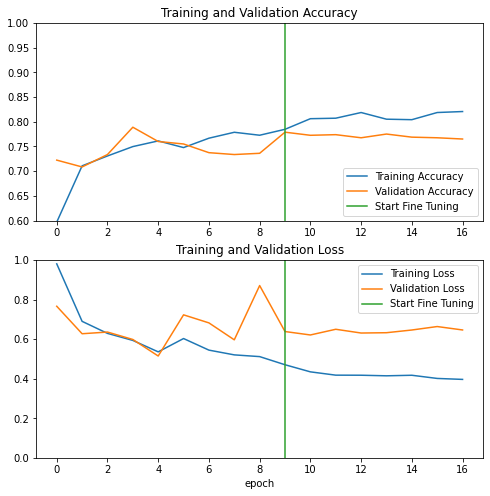

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
## lets load the model which has the best training accuracy

model = keras.models.load_model('ResNet50_model_aug_wgts.h5')

Predictions:
 [2 0 3 2 2 2 0 2 0 2 2 2 0 2 2 2 2 1 2 2 3 2 2 0 0 0 0 2 0 0 2 2]
Labels:
 [2 0 3 2 2 2 0 2 0 2 0 2 0 2 2 3 2 1 2 0 3 2 3 0 3 0 0 2 3 0 2 2]


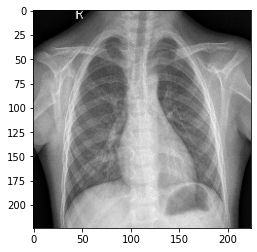

True label: Normal
Prediction: Normal


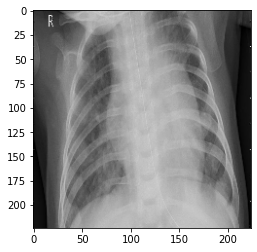

True label: BacterialPneumonia
Prediction: BacterialPneumonia


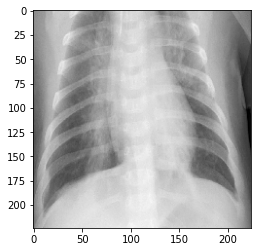

True label: ViralPneumonia
Prediction: ViralPneumonia


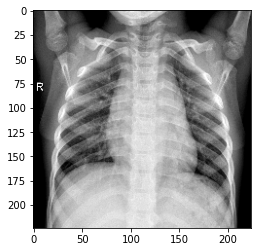

True label: Normal
Prediction: Normal


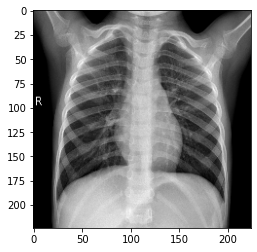

True label: Normal
Prediction: Normal


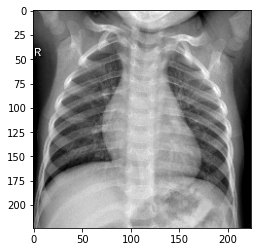

True label: Normal
Prediction: Normal


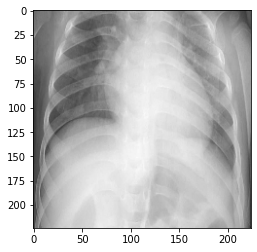

True label: BacterialPneumonia
Prediction: BacterialPneumonia


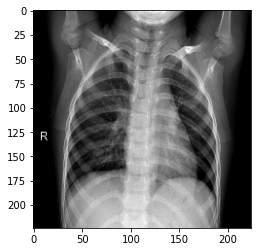

True label: Normal
Prediction: Normal


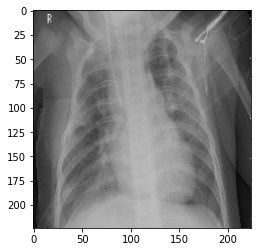

True label: BacterialPneumonia
Prediction: BacterialPneumonia


In [45]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# Apply a softmax since our model returns logits
predictions = tf.nn.softmax(predictions)
predictions = np.argmax(predictions, axis=1)

print('Predictions:\n', predictions)
print('Labels:\n', label_batch)

plt.figure()
for i in range(9):
  #ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.show()
  print('True label: %s' % class_names[label_batch[i]])
  print('Prediction: %s' % class_names[predictions[i]])

In [46]:
from sklearn.metrics import classification_report, confusion_matrix

report = classification_report(label_batch, predictions, target_names=class_names)
print(report) 



                    precision    recall  f1-score   support

BacterialPneumonia       0.80      0.80      0.80        10
          COVID-19       1.00      1.00      1.00         1
            Normal       0.79      1.00      0.88        15
    ViralPneumonia       1.00      0.33      0.50         6

          accuracy                           0.81        32
         macro avg       0.90      0.78      0.80        32
      weighted avg       0.84      0.81      0.79        32

